In [78]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns

plt.style.use('seaborn')

Load the data

In [12]:
with open('logins.json') as f:
    raw_data = json.load(f)
    
logins_str = pd.Series(raw_data['login_time'])
logins_time = pd.to_datetime(logins_str,infer_datetime_format=True)

Check for formatting issues within the data

In [19]:
logins_time.isnull().values.any()

False

Extract features from timestamps for processing this includes
- Month
- Day
- Day of the week
- Hour
- Minute to a rounded version of the minute field, useful for grouping data without being so specific that there isn't enough data per group

In [179]:
df = pd.DataFrame({'time':logins_time,'month':logins_time.dt.month,'day':logins_time.dt.day, 
                   'day_of_week':logins_time.dt.dayofweek,'hour':logins_time.dt.hour,'minute':logins_time.dt.minute})
df.head()

,time,month,day,day_of_week,hour,minute
0,1970-01-01 20:13:18,1,1,3,20,13
1,1970-01-01 20:16:10,1,1,3,20,16
2,1970-01-01 20:16:37,1,1,3,20,16
3,1970-01-01 20:16:36,1,1,3,20,16
4,1970-01-01 20:26:21,1,1,3,20,26


In [26]:
def round_minutes(minute):
    if minute >= 45:
        return 45
    elif minute >= 30:
        return 30
    elif minute >= 15:
        return 15
    else:
        return 0

In [180]:
df['rounded_min'] = df.minute.apply(round_minutes)
df.head(6)

,time,month,day,day_of_week,hour,minute,rounded_min
0,1970-01-01 20:13:18,1,1,3,20,13,0
1,1970-01-01 20:16:10,1,1,3,20,16,15
2,1970-01-01 20:16:37,1,1,3,20,16,15
3,1970-01-01 20:16:36,1,1,3,20,16,15
4,1970-01-01 20:26:21,1,1,3,20,26,15
5,1970-01-01 20:21:41,1,1,3,20,21,15


Track data per day of the 102 days given in the data, inspect for patterns
- Overall login counts are increasing as shown by the linear regression model
- Counts follow a cyclic pattern possibly indicating that there is a correlation between data and the day of the week
- Strange behavior from day ~73 - 80, investigate with business teams for possible causes

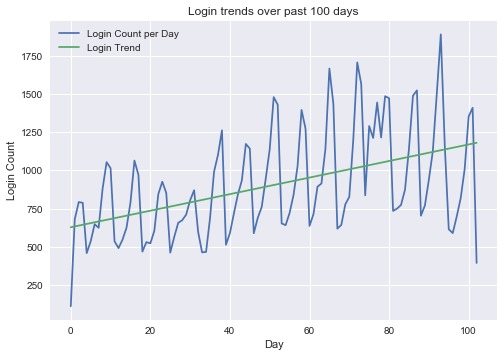

In [56]:
days = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

logins_by_day = df.groupby(['month','day'])['time'].count()

#Raw Data
plt.plot(logins_by_day.values, label='Login Count per Day')

#Regression Line
results = sm.OLS(logins_by_day,sm.add_constant(logins_by_day.reset_index(drop=True).index.values)).fit()

X_plot = np.linspace(0,102,100)
plt.plot(X_plot, X_plot*results.params[1] + results.params[0], label='Login Trend')

plt.legend()
plt.xlabel('Day')
plt.ylabel('Login Count')
_ = plt.title('Login trends over past 100 days')

Inspect trends by day of week over time, this is done because of observations made in previous chart
- No significant patterns over time are seen between days of week
- It is obvious that there is a correlation between days of week in general and the login counts, but this relationship remains relatively constant over time and follows the high level patterns of a general increase in logins

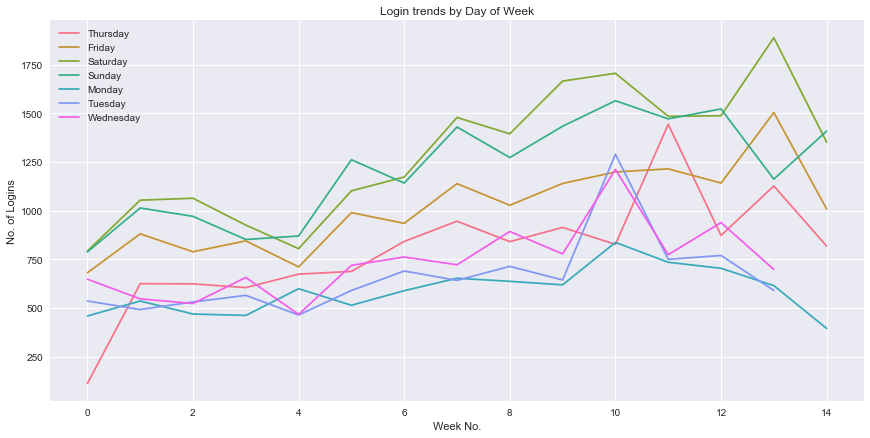

In [175]:
logins_by_day_w_dow = df.groupby(['month','day','day_of_week'])['time'].count().reset_index()[['day_of_week','time']]
logins_by_day_w_dow.day_of_week = logins_by_day_w_dow.day_of_week.map(days)

g = sns.FacetGrid(logins_by_day_w_dow,hue='day_of_week',height=6,aspect=2)
g.map(plt.plot, 'time')

plt.legend()
plt.title('Login trends by Day of Week')
plt.xlabel('Week No.')
_ = plt.ylabel('No. of Logins')

Investigate the relationships between the day of the week and the login counts, as the charts above both showed there to be a correlation of some kind
- The counts are significantly higher on the weekends and increase throughout the week

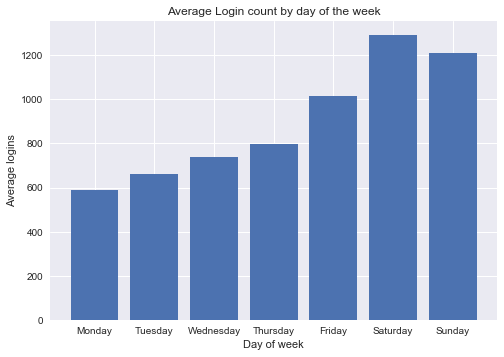

In [181]:
avg_by_day_of_week = df.groupby(['month','day','day_of_week'])['time'].count().reset_index().groupby(['day_of_week'])['time'].mean()

plt.bar(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], avg_by_day_of_week.values)

plt.xlabel('Day of week')
plt.ylabel('Average logins')
_ = plt.title('Average Login count by day of the week')

Finally investigate the login count distirbution over the span of each day of the week
- Two distinct distributions are shown, one for the weekend and one for the week days
<br><br>
<b>Weekdays</b>
- Week days peak late at night, 10 PM to 2 AM, and midday, 11 AM to 1 PM
- The later in the week the greater the late night peak seems to be however the midday peak remains constant for all weekdays
<br><br>
<b>Weekends</b>
- Weekends are more evenly distributed but still peak very early morning, midnight to 5 AM with a very sharp drop off after 5 AM
- Weekend logins remain very low until about 1 PM where it stays constant at ~10-15 logins until again that late that night

In [182]:
distribution_by_day_of_week = df.groupby(['month','day','day_of_week','hour','rounded_min'])['time'].count().reset_index() \
                                .groupby(['day_of_week','hour','rounded_min'])['time'].mean()

distribution_by_day_of_week = distribution_by_day_of_week.reset_index()
distribution_by_day_of_week.day_of_week = distribution_by_day_of_week.day_of_week.map(days)
distribution_by_day_of_week.columns = ['day_of_week','hour','rounded_min','avg_logins']

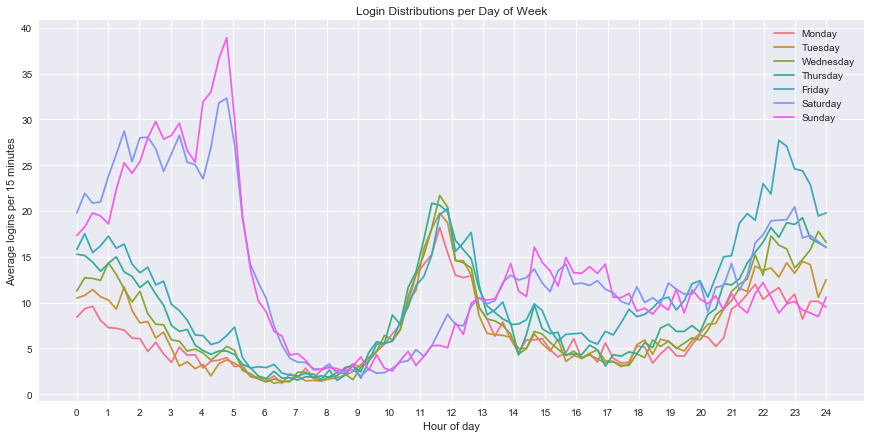

In [168]:
g = sns.FacetGrid(distribution_by_day_of_week[['day_of_week','avg_logins']],hue='day_of_week',height=6,aspect=2)
g.map(plt.plot, 'avg_logins')

plt.legend()
plt.xlabel('Hour of day')
plt.ylabel('Average logins per 15 minutes')
plt.title('Login Distributions per Day of Week')
_ = plt.xticks((pd.Series(range(0,25)) * (95 / 24)),pd.Series(range(0,25)))